# Проект: Статистический анализ данных

**Контекст:** Популярный сервис аренды самокатов GoFast. Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках.Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки
   - абонентская плата отсутствует;
   - стоимость одной минуты поездки — 8 рублей;
   - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
   - абонентская плата — 199 рублей в месяц;
   - стоимость одной минуты поездки — 6 рублей;
   - стоимость старта — бесплатно.

**Задачи:** Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.

**Описание данных:** 

*Пользователи — users_go.csv:*
- user_id - уникальный идентификатор пользователя;
- name - имя пользователя;
- age - возраст;
- city - город;
- subscription_type - тип подписки (free, ultra).

*Поездки — rides_go.csv:*
- user_id - уникальный идентификатор пользователя;
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах);
- duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»;
- date - дата совершения поездки.

*Подписки — subscriptions_go.csv:*
- subscription_type - тип подписки;
- minute_price - стоимость одной минуты поездки по данной подписке;
- start_ride_price - стоимость начала поездки;
- subscription_fee - стоимость ежемесячного платежа.

**Содержание:**
1. [Загрузка данных и изучение общей информации](#chapter1)
2. [Предобработка данных](#chapter2)
3. [Исследовательский анализ данных](#chapter3)
4. [Объединение данных](#chapter4)
5. [Подсчёт выручки](#chapter5)
6. [Проверка гипотез](#chapter6)
7. [Общий вывод](#chapter7)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

<a id="chapter1"></a>
###  Загрузка данных и изучение общей информации

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

**1.1 Посмотрим основную информацию о датафреймах**

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**1.2 Проверим явные дубликаты**

In [9]:
users.duplicated().sum()

31

In [10]:
rides.duplicated().sum()

0

**Вывод**

В данных нет пропусков, но есть явные дубликаты в датафрейме users, их количество составило 31. Также в датафрейме rides некорректный тип данных столбца date.

<a id="chapter2"></a>

### Предобработка данных

**2.1  Изменим тип данных датафрейма rides столбца date**

In [11]:
rides['date'] = pd.to_datetime(rides['date'], format = '%Y-%m-%d')
rides['date'].head()

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

**2.2 Создадим новый столбец с номером месяца на основе столбца date в таблице rides**

In [12]:
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


**2.3 Удалим явные дубликаты в датафрейме users**

In [13]:
users = users.drop_duplicates().reset_index(drop=True)
users.duplicated().sum()

0

**Вывод** 

В данном разделе удалили явные дубликаты. В датафрейма rides создали новыый столбец с месяцами и в столбце date изменили тип данных.

<a id="chapter3"></a>

###  Исследовательский анализ данных

**3.1 Частота встречаемости городов**

In [14]:
users_city = users['city'].value_counts()
users_city

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

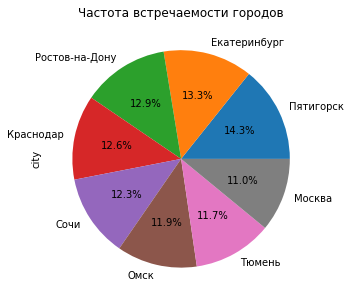

In [15]:
users['city'].value_counts().plot(
    kind = 'pie',
    y = users_city,
    autopct = '%1.1f%%',
    title = 'Частота встречаемости городов',
    figsize=(5,5))
plt.show()

Количество пользователей в зависимости от городов примерно одинаковое. Больше пользователей находится в Пятигорске - 14.3%, а меньше всего пользователей в Москве - 11.0%.

**3.2 Cоотношение пользователей с подпиской и без подписки**

In [16]:
users_subscription_type = users['subscription_type'].value_counts()
users_subscription_type

free     835
ultra    699
Name: subscription_type, dtype: int64

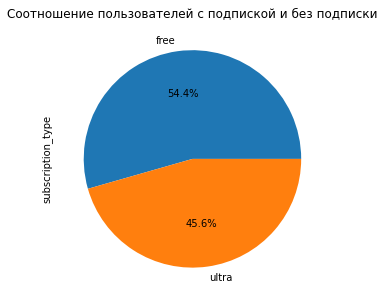

In [17]:
users['subscription_type'].value_counts().plot(
    kind = 'pie',
    y = users_subscription_type,
    autopct = '%1.1f%%',
    title = 'Cоотношение пользователей с подпиской и без подписки',
    figsize=(5,5))
plt.show()

Количество пользователей с подпиской меньше - 45.6%, чем без - 54.4%

**3.3 Возраст пользователей**

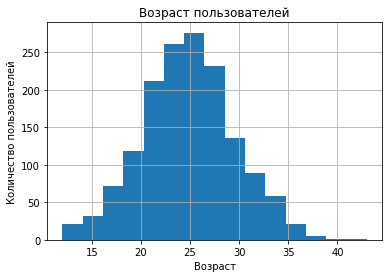

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [18]:
users['age'].hist(bins=15)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()
users['age'].describe()

Среднее число пользователей в возрасте от 22 до 28 лет. Максимальный возраст пользователей 43 года, а минимальный 12 лет

**3.4 Расстояние, которое пользователь преодолел за одну поездку**

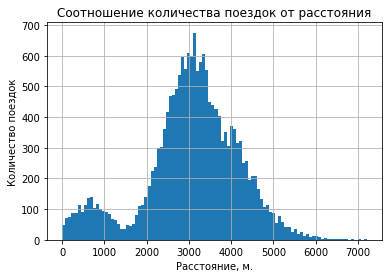

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

In [19]:
rides['distance'].hist(bins=100)
plt.title('Соотношение количества поездок от расстояния')
plt.xlabel('Расстояние, м.')
plt.ylabel('Количество поездок')
plt.show()
rides['distance'].describe()

В основном расстояние поездки составляет от 2.5 км. до 3.8 км. Самая короткая поездка составила 0,85 м., а самая длинная 7,2 км.

**3.5 Продолжительность поездок**

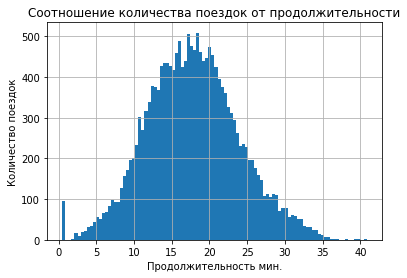

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [20]:
rides['duration'].hist(bins=100)
plt.title('Соотношение количества поездок от продолжительности')
plt.xlabel('Продолжительность мин.')
plt.ylabel('Количество поездок')
plt.show()
rides['duration'].describe()

Самая короткая поездка составила 0.5 мин., а самая длинная 40 мин. В среднем продолжительность поездки составляет 17 мин.

<a id="chapter4"></a>

###  Объединение данных

**4.1 Объединим данные о пользователях, поездках и подписках в один датафрейм**

In [50]:
data = users.merge(rides, on='user_id')
data = data.merge(subscriptions, on='subscription_type')
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


**4.2 Создадим датафрейм с данными о пользователях с подпиской**

In [22]:
data_ultra = data.query('subscription_type == "ultra"')
data_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


**4.3 Создадим датафрейм с данными о пользователях без подписки**

In [46]:
data_free = data.query('subscription_type == "free"')
data_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [48]:
data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

**4.4 Визуализируем информацию о расстоянии и времени поездок для пользователей категоррий ultra и free**

4.4.1 Категория ultra. Расстояние, которое пользователь преодолел за одну поездку

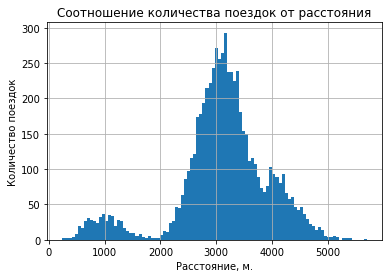

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [24]:
data_ultra['distance'].hist(bins=100)
plt.title('Соотношение количества поездок от расстояния')
plt.xlabel('Расстояние, м.')
plt.ylabel('Количество поездок')
plt.show()
data_ultra['distance'].describe()

4.4.2 Категория ultra. Продолжительность поездок

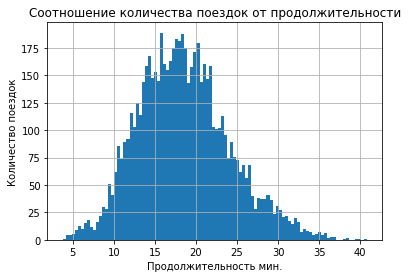

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [25]:
data_ultra['duration'].hist(bins=100)
plt.title('Соотношение количества поездок от продолжительности')
plt.xlabel('Продолжительность мин.')
plt.ylabel('Количество поездок')
plt.show()
data_ultra['duration'].describe()

4.4.3 Категория free. Расстояние, которое пользователь преодолел за одну поездку

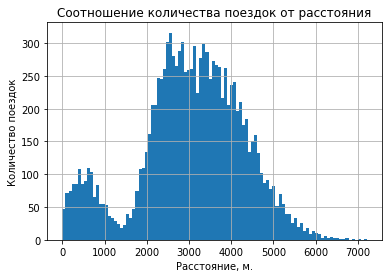

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [26]:
data_free['distance'].hist(bins=100)
plt.title('Соотношение количества поездок от расстояния')
plt.xlabel('Расстояние, м.')
plt.ylabel('Количество поездок')
plt.show()
data_free['distance'].describe()

4.4.4 Категория free. Продолжительность поездок

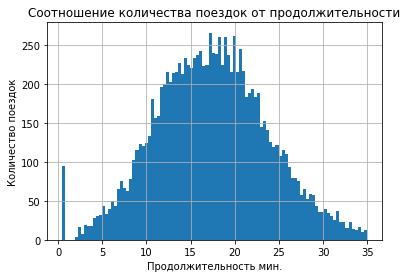

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [27]:
data_free['duration'].hist(bins=100)
plt.title('Соотношение количества поездок от продолжительности')
plt.xlabel('Продолжительность мин.')
plt.ylabel('Количество поездок')
plt.show()
data_free['duration'].describe()

**Вывод**

В данном разделе разделили пользователей на две категории: free - без подписки и ultra - с подпиской

Пользователи категории free имеют продолжительность поездки от 12.9 до 22 мин. и расстоянием от 2.3 до 3.9 км.

Пользователи категории ultra имеют продолжительность поездки от 14.5 до 22 мин. и расстоянием от 2.7 до 3.6 км.

По этим данным можно сделать вывод, что пользователи категории ultra имеют меньший разброс по данным (Расстояние: видно из графиков и по стандартному отклонению free - 1246,17 ultra - 836.89 и продолжительность: стандартное отклонение free - 6.33 ultra - 5.57). Поэтому можно сказать о том, что подписка влияет на расстояние поездок и на время пути.

<a id="chapter5"></a> 

###  Подсчёт выручки

**5.1 Найдем суммарное расстояние, количество поeздок и суммарное время для каждого пользователя за каждый месяц**

In [51]:
data['duration'] = np.ceil(data['duration']) #округлим время поездки

data_pivot = data.pivot_table( #создаем сводную таблицу
    index=('month', 'user_id'), 
    values=(
        'distance', 
        'duration', 
        'minute_price', 
        'start_ride_price', 
        'subscription_fee'), 
    aggfunc=('count', 'sum'))

data_pivot.columns = [  #переименнуем столбцы
    'count', 'distance', 
    'count2', 'duration', 
    'count3', 'minute_price',
    'count4', 'start_ride_price', 
    'count5', 'subscription_fee']

data_pivot = data_pivot.drop(['count2', 'count3', 'count4', 'count5'], axis=1) #удалим повторяющиеся столбцы

data_pivot['minute_price'] = data_pivot['minute_price'] / data_pivot['count'] #вернем исходные значения
data_pivot['start_ride_price'] = data_pivot['start_ride_price'] / data_pivot['count'] #вернем исходные значения
data_pivot['subscription_fee'] = data_pivot['subscription_fee'] / data_pivot['count'] #вернем исходные значения

data_pivot

count     distance  duration  minute_price  start_ride_price  \
month user_id                                                                 
1     1            2  7027.511294      42.0           6.0               0.0   
      3            1  3061.777147      13.0           6.0               0.0   
      5            1  3914.646990      13.0           6.0               0.0   
      7            2  6478.080979      28.0           6.0               0.0   
      12           1  3577.151148      33.0           6.0               0.0   
...              ...          ...       ...           ...               ...   
12    1525         1  4597.854350      34.0           8.0              50.0   
      1526         1  3644.121544      23.0           8.0              50.0   
      1528         1  3998.569324      11.0           8.0              50.0   
      1532         2  6111.889853      42.0           8.0              50.0   
      1534         1  2371.711192      16.0           8.0              50.0   

               subscription_fee  
month user_id                    
1     1                   199.0  
      3                   199.0  
      5                   199.0  
      7                   199.0  
      12                  199.0  
...                         ...  
12    1525                  0.0  
      1526                  0.0  
      1528                  0.0  
      1532                  0.0  
      1534                  0.0  

[11331 rows x 6 columns]

**5.2 Добавим в датафрейм столбец с помесячной выручкой**

In [29]:
data_pivot['month_revenue'] = (
    (data_pivot['start_ride_price'] * data_pivot['count']) 
    + (data_pivot['minute_price'] * data_pivot['duration']) 
    + data_pivot['subscription_fee']
)
data_pivot

count     distance  duration  minute_price  start_ride_price  \
month user_id                                                                 
1     1            2  7027.511294      42.0           6.0               0.0   
      3            1  3061.777147      13.0           6.0               0.0   
      5            1  3914.646990      13.0           6.0               0.0   
      7            2  6478.080979      28.0           6.0               0.0   
      12           1  3577.151148      33.0           6.0               0.0   
...              ...          ...       ...           ...               ...   
12    1525         1  4597.854350      34.0           8.0              50.0   
      1526         1  3644.121544      23.0           8.0              50.0   
      1528         1  3998.569324      11.0           8.0              50.0   
      1532         2  6111.889853      41.0           8.0              50.0   
      1534         1  2371.711192      16.0           8.0              50.0   

               subscription_fee  month_revenue  
month user_id                                   
1     1                   199.0          451.0  
      3                   199.0          277.0  
      5                   199.0          277.0  
      7                   199.0          367.0  
      12                  199.0          397.0  
...                         ...            ...  
12    1525                  0.0          322.0  
      1526                  0.0          234.0  
      1528                  0.0          138.0  
      1532                  0.0          428.0  
      1534                  0.0          178.0  

[11331 rows x 7 columns]

In [30]:
data_pivot['month_revenue'].sum()

3853677.0

**Вывод**

В данном разделе создали новый датафрейм с помесячной выручкой, которую принес каждый пользователь. Суммарно выручка за год составила 3853677 р.

<a id="chapter6"></a>

###  Проверка гипотез

**6.1 Тратят ли пользователи с подпиской больше времени на поездки?** 

Нулевая гипотеза: Пользователи с категориями ultra и free тратят одинаковое время на поездки

Альтернативная гипотеза: Пользователи с категориями ultra тратят больше времени на поездки

In [33]:
ultra = data_ultra['duration']
free = data_free['duration']

alpha = 0.05 

results = st.ttest_ind(
    ultra, 
    free,
    alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Пользователи с подпиской тратят больше времени на поездки, поэтому они могут быть «выгоднее» для компании

**6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?**

Нулевая гипотеза: Среднее расстояние, которое проезжают пользователи с подпиской равно 3130 м.

Альтернативная гипотеза: Среднее расстояние, которое проезжают пользователи с подпиской больше 3130 м.

In [35]:
ultra_distance = data_ultra['distance']

distance_one = 3130

alpha = 0.05

results = st.ttest_1samp(
    ultra_distance, 
    distance_one,
    alternative='less')
    
print(results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

0.08046311521502146
Не удалось отвергнуть нулевую гипотезу


Мы не можем быть точно увереными в том, что пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку

**6.3 Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки** 

Нулевая гипотеза: Одинаковая ли помесячная выручка у пользователей с категорией ultra и free

Альтернативная гипотеза: Помесячная выручка по категории пользователей ultra больше чем по категории пользователей free

In [42]:
ultra_month_revenue = data_pivot.loc[data_pivot['subscription_fee'] > 0, 'month_revenue']
free_month_revenue = data_pivot.loc[data_pivot['subscription_fee'] == 0, 'month_revenue']

alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(
    ultra_month_revenue, 
    free_month_revenue,
    alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 2.8130926188487286e-35
Отвергаем нулевую гипотезу


Мы не можем утверждать, что помесячная выручка категории пользователей ultra превышает выручку с пользователей free

**6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?**

Нулевая гипотеза: Количество обращений после обновления сервера не изменилось

Альтернативная гипотеза: Количество обращений в техподдержку после обновления сервера уменьшилось

Будем использовать гипотезу о равенстве средних для зависимых (парных) выборок.
Применим метод scipy.stats.ttest_rel()

<a id="chapter7"></a>
###  Общий вывод

**В данном проекте были выполнены следующие работы**

*Изучена общая информация о данных*

*Предобработка данных:* 

- изменили тип данных датафрейма rides столбца date
- создали новый столбец с номером месяца на основе столбца date в таблице rides
- удалены явные дубликаты

*Исследовательский анализ данных:*

- выявили, что количество пользователей в зависимости от городов примерно одинаковое. Больше пользователей находится в Пятигорске - 14.3%, а меньше всего пользователей в Москве - 11.0%
- пользователей использующих подписку всего 45,6%, а без подписки 54.4%
- возраст пользователей составил в среднем от 22 до 28 лет. Максимальный возраст 43 года, а минимальный 12 лет
- в среднем расстояние поездки составляет от 2.5 км. до 3.8 км. Самая короткая поездка составила 0,85 м., а самая длинная 7,2 км.
- самая короткая поездка составила 0.5 мин., а самая длинная 40 мин. В среднем продолжительность поездки составляет 17 мин.

*Объединение данных*

- объединили данные о пользователях, поездках и подписках в один датафрейм
- создали ещё два датафрейма c данными о пользователях без подписки - free и с подпиской - ultra
- визуализировали информацию о расстоянии и времени поездок для пользователей обеих категорий
- выявили, что подписка влияет на расстояние поездок и на время пути

*Подсчёт выручки*

- создали датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4
- в этот же датафрейм добавили столбец с помесячной выручкой, которую принёс каждый пользователь
- посчитали выручку за год, она составила 3853677 р.

*Проверка гипотез*

- пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки (Отвергли нулевую гипотезу)
- среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров (Не удалось отвергнуть нулевую гипотезу)
- помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки (Отвергли нулевую гипотезу)
- метод scipy.stats.ttest_rel() необходимый для проверки гипотезы о равенстве средних для зависимых (парных) выборок. 